# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Описание данных:\
\
RowNumber — индекс строки в данных\
CustomerId — уникальный идентификатор клиента\
Surname — фамилия\
CreditScore — кредитный рейтинг\
Geography — страна проживания\
Gender — пол\
Age — возраст\
Tenure — сколько лет человек является клиентом банка\
Balance — баланс на счёте\
NumOfProducts — количество продуктов банка, используемых клиентом\
HasCrCard — наличие кредитной карты\
IsActiveMember — активность клиента\
EstimatedSalary — предполагаемая зарплата\
Целевой признак\
Exited — факт ухода клиента\

## Подготовка данных

In [1]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, recall_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
#data.head(10)

In [4]:
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5775,5776,15717527,Ifeanacho,619,France,Female,49,9.0,145359.99,1,1,0,38186.85,0
8830,8831,15810444,Aksenov,562,Germany,Female,39,6.0,130565.02,1,1,0,9854.72,1
2799,2800,15775662,McKay,760,France,Male,43,8.0,121911.59,1,1,0,193312.33,0
6806,6807,15795586,McDonald,478,France,Male,35,1.0,92474.05,1,1,0,178626.07,0
3584,3585,15664227,Threatt,506,Germany,Male,28,8.0,53053.76,1,0,1,24577.34,0
9295,9296,15740868,Pirogova,658,Germany,Female,45,9.0,134562.80,1,1,1,159268.67,0
1392,1393,15730540,Simpson,794,Spain,Male,45,8.0,88656.37,2,1,0,116547.31,0
2247,2248,15785485,Zhou,595,Germany,Female,41,2.0,138878.81,1,0,1,112269.67,0
1335,1336,15576683,Yin,568,Spain,Female,43,9.0,0.00,1,1,0,125870.79,1
7828,7829,15581286,Castro,734,France,Female,40,9.0,176914.80,1,1,1,12799.23,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [8]:
data.duplicated().sum()

0

Приведем название столбцов в змеиный регистр.

In [10]:
data = data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())

0    7963
1    2037
Name: exited, dtype: int64


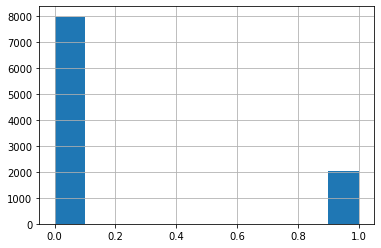

In [11]:
print(data['exited'].value_counts())
data['exited'].hist();

In [12]:
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Столбец tenure содержит пропуски. Возможно это связано с тем что клиент пользуется услугами банка менее 1 года, а возможно данные просто не были заполнены. Чтобы не терять часть данных датасета, заменим пропуски медианным значением и приведем в целочисленный вид.

In [14]:
data['tenure'] = data['tenure'].mask(data['tenure'].isna(), np.random.randint(0, 10, size=len(data)))
data['tenure'].isna().sum()

0

In [15]:
data['tenure'] = data['tenure'].astype('int')

## Исследование задачи

Так как столбцы row_number, customer_id и surname не несут в себе информации, необходимой для дальнейшей классификации, удалим их.

In [16]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [17]:
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [18]:
def value_columns(data):
    for column in data:
        print('Количество значений в столбце', column)
        print(data[column].value_counts())        
value_columns(data)

Количество значений в столбце credit_score
850    233
678     63
655     54
667     53
705     53
      ... 
412      1
351      1
365      1
373      1
423      1
Name: credit_score, Length: 460, dtype: int64
Количество значений в столбце geography
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
Количество значений в столбце gender
Male      5457
Female    4543
Name: gender, dtype: int64
Количество значений в столбце age
37    478
38    477
35    474
36    456
34    447
     ... 
92      2
88      1
82      1
85      1
83      1
Name: age, Length: 70, dtype: int64
Количество значений в столбце tenure
2     1050
1     1046
8     1028
5     1026
3     1013
7     1013
9      969
4      968
6      965
0      476
10     446
Name: tenure, dtype: int64
Количество значений в столбце balance
0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85    

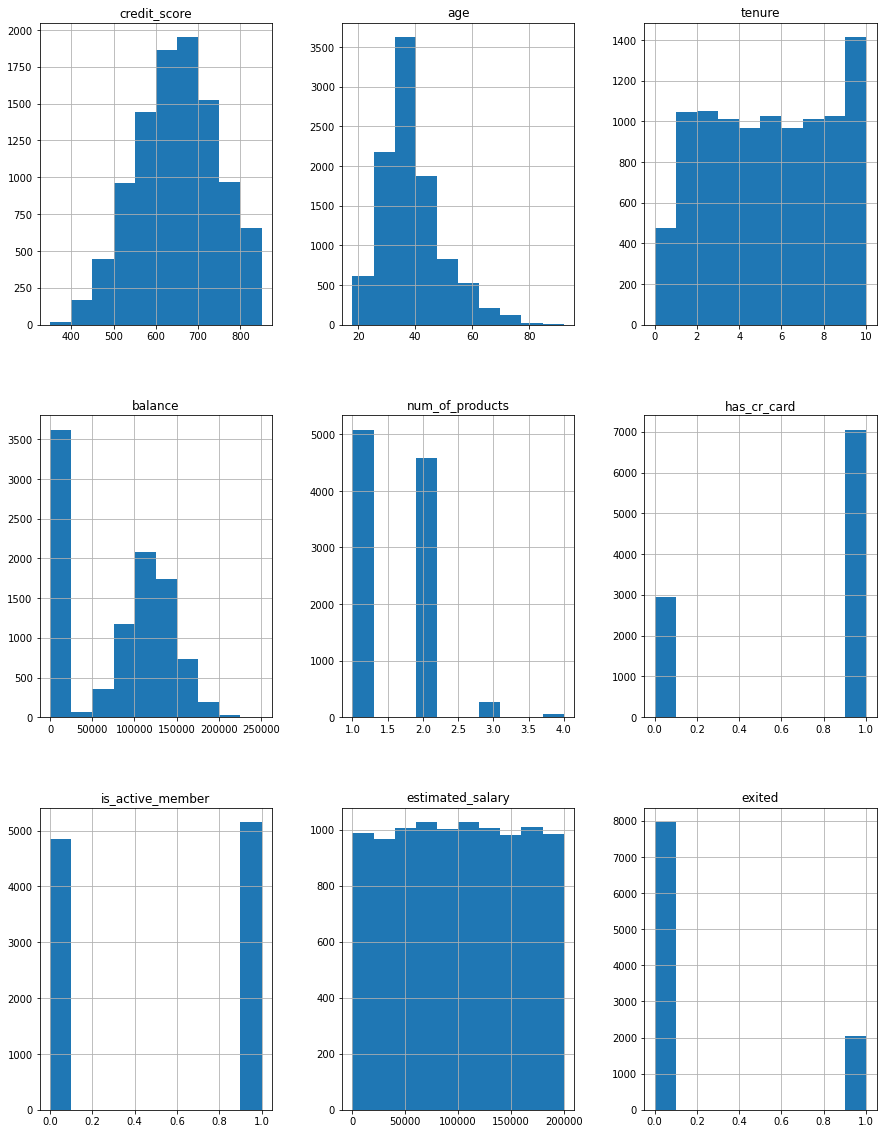

In [19]:
data.hist(figsize=(15, 20));

При рассмотрении столбцов с признаками можно отметить, что в столбце с целевыми признаками наблюдается дисбаланс классов 4:1. В выборке представлены клиенты, где 79.63% - остались с банком, а 20.37% ушли от банка.

In [22]:
features = data.drop('exited', axis=1)
target = data['exited']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
     features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
     features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)


ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['geography', 'gender']


Превратим датасет в набор выборок для модели.

In [24]:
features = data.drop('exited', axis=1)
target = data['exited']

In [25]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)
print(f"Количество строк по классам: {np.bincount(target_test)}")
print(f"Количество строк по классам: {np.bincount(target_valid)}")
print(f"Количество строк по классам: {np.bincount(target_train)}")

Количество строк по классам: [1593  407]
Количество строк по классам: [1592  408]
Количество строк по классам: [4778 1222]


In [26]:
len(features_train)/len(features)

0.6

In [27]:
len(features_valid)/len(features)

0.2

In [28]:
len(features_test)/len(features)

0.2

In [29]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

Произведем масштабирование данных численных признаков.

In [30]:
pd.options.mode.chained_assignment = None
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [31]:
display(features_train)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.356662,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,0.702097,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.047532,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,1.047532,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.370514,0.879129,-0.914708,1,0,0.113236,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6172,-0.844611,0.381372,0.011227,0.180068,4.292357,1,1,0.117350,1,0,1
2360,-1.359935,0.190726,0.011227,0.547724,-0.914708,1,0,-0.192524,1,0,0
4499,-1.174418,0.476696,-0.334208,0.727840,-0.914708,0,0,0.531933,1,0,0
9162,0.155118,2.287837,0.702097,0.449382,-0.914708,1,1,-1.307769,1,0,1


**Решающее дерево**

In [32]:
best_tree = None
best_f1 = 0
best_depth = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid,predictions_valid)
    if f1 > best_f1:
        best_tree = model
        best_f1 = f1
        best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Глубина дерева лучшей модели: ', best_depth)   

F1-мера лучшей модели:  0.5953757225433526
Глубина дерева лучшей модели:  7


**Случайный лес**

In [33]:
best_forest = None
best_f1 = 0
best_est = 0
best_depth = 0
for est in tqdm(range(10, 100, 10)):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid) 
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_forest = model
            best_f1 = f1
            best_est = est
            best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Количество деревьев лучшей модели: ', best_est)
print('Глубина деревьев лучшей модели: ', best_depth)

100%|██████████| 9/9 [00:50<00:00,  5.64s/it]

F1-мера лучшей модели:  0.6262924667651404
Количество деревьев лучшей модели:  80
Глубина деревьев лучшей модели:  17


**Логистическая регрессия**

In [34]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid)
print('F1 модели логистической регрессии:', f1)
print('ROC_auc:', roc_auc)

F1 модели логистической регрессии: 0.3076923076923077
ROC_auc: 0.5859813774756133


#### **Вывод**
В данном разделе мы обучили 3 типа моделей на данных с учетом имеющегося дисбаланса. Метрика F1 модели логистической регрессии существенно ниже, чем у моделей дерева решений и случайного леса.
На валидационной выборке наилучшее качество (F1=0,62) продемонстрировала модель случайного леса с гиперпараметрами: количество деревьев - 40, максимальная глубина деревьев: 13.

## Борьба с дисбалансом

Для решения проблемы дисбаланса используем и сравним результаты трех методов: взвешивание классов, увеличение выборки, уменьшение выборки и попробуем добиться значения F1 выше, чем 0,59.

**Взвешивание классов**

1. Решающее дерево

F1-мера лучшей модели:  0.575925925925926
Глубина дерева лучшей модели:  6
AUC-ROC модели: 0.7883773955562126


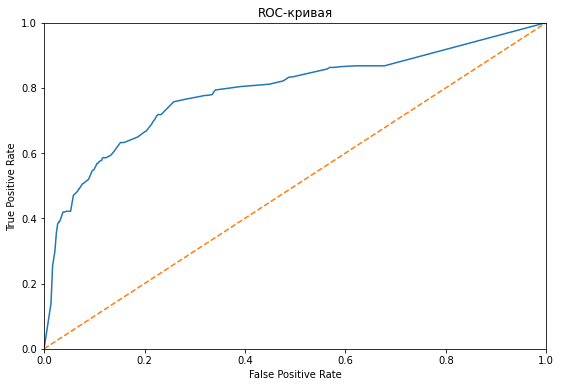

In [35]:
best_tree = None
best_f1 = 0
best_depth = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_tree = model
        best_f1 = f1
        best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Глубина дерева лучшей модели: ', best_depth)  

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_tree, tpr_tree)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

2. Случайный лес

100%|██████████| 24/24 [16:31<00:00, 41.32s/it]


F1-мера лучшей модели:  0.6513233601841196
Количество деревьев лучшей модели:  180
Глубина деревьев лучшей модели:  9
AUC-ROC модели: 0.8651468124938417


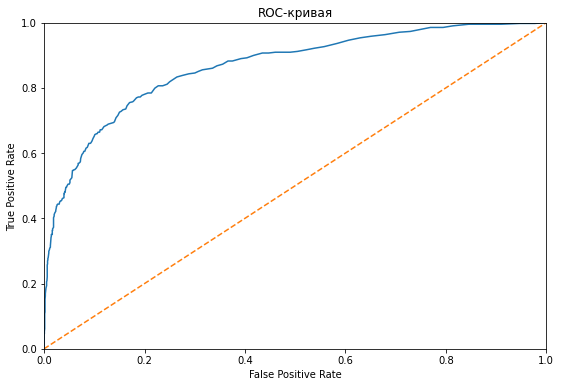

In [36]:
best_forest = None
best_f1 = 0
best_depth = 0
best_est = 0
for est in tqdm(range(10, 250, 10)):
    for depth in range(1, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_forest = model
            best_f1 = f1
            best_est = est
            best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Количество деревьев лучшей модели: ', best_est)
print('Глубина деревьев лучшей модели: ', best_depth)            

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_forest, tpr_forest)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

3. Логистическая регрессия

F1 модели логистической регрессии: 0.5285338015803336
ROC_auc: 0.7338222977633265
AUC-ROC модели: 0.7936342250468027


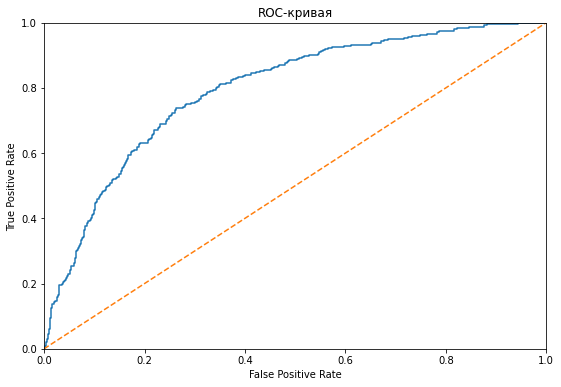

In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid)
print('F1 модели логистической регрессии:', f1)
print('ROC_auc:', roc_auc)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_log, tpr_log, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_log, tpr_log)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

<Figure size 432x288 with 0 Axes>

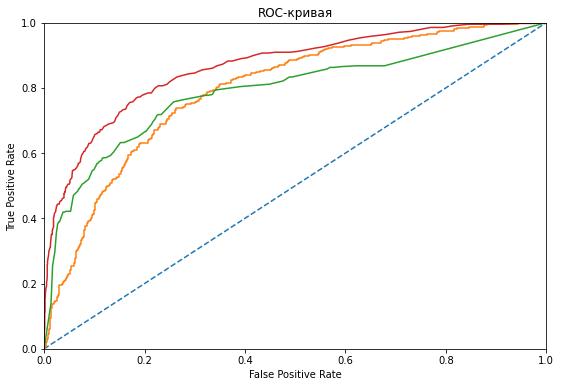

In [38]:
plt.figure()
plt.figure(figsize=(9,6));
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log, tpr_log, label = 'Логистическая регрессия')
plt.plot(fpr_tree, tpr_tree, label = 'Решающее дерево')
plt.plot(fpr_forest, tpr_forest, label = 'Случайный лес')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Использование взвешивания классов существенно улучшило показатель метрики F1 у всех моделей, но у случайного леса также  остались более высокие значения метрик.

**Увеличение выборки**

1    0.50569
0    0.49431
Name: exited, dtype: float64


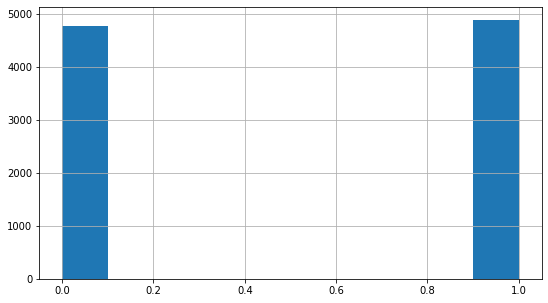

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(target_upsampled.value_counts(normalize = 1))
target_upsampled.hist(figsize=(9, 5));

1. Решающее дерево

F1-мера лучшей модели:  0.575925925925926
Глубина дерева лучшей модели:  6
AUC-ROC модели: 0.7909030446349394


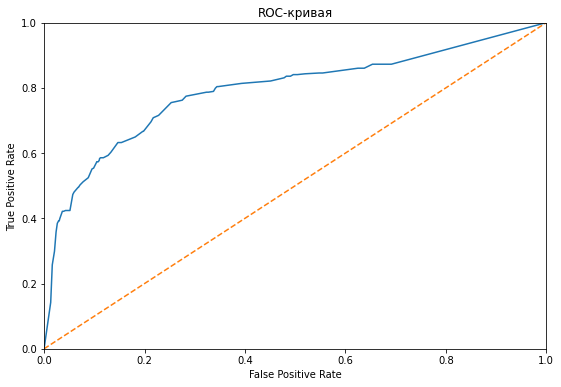

In [40]:
best_tree = None
best_f1 = 0
best_depth = 0
for depth in range(1,10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_tree = model
        best_f1 = f1
        best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Глубина дерева лучшей модели: ', best_depth)  

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_tree, tpr_tree, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_tree, tpr_tree)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

2. Случайный лес

F1-мера лучшей модели:  0.6519337016574587
Количество деревьев лучшей модели:  220
Глубина деревьев лучшей модели:  10
AUC-ROC модели: 0.8636919277761355


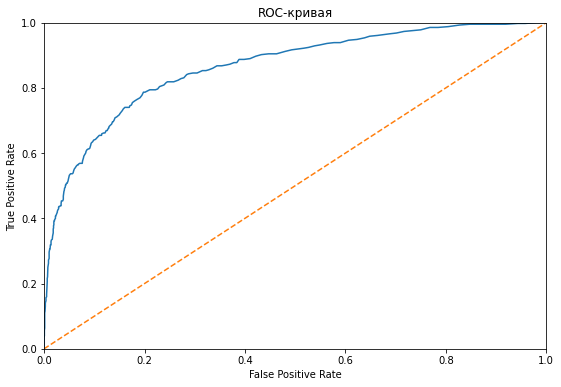

In [41]:
best_forest = None
best_f1 = 0
best_est = 0
best_depth = 0
for est in range(10, 250, 10):
    for depth in range(1, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_forest = model
            best_f1 = f1
            best_est = est
            best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Количество деревьев лучшей модели: ', best_est)
print('Глубина деревьев лучшей модели: ', best_depth) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_forest, tpr_forest)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

3. Логистическая регрессия

F1 модели логистической регрессии: 0.6121372031662269
ROC_auc: 0.7472534239826584
AUC-ROC модели: 0.7936927283476205


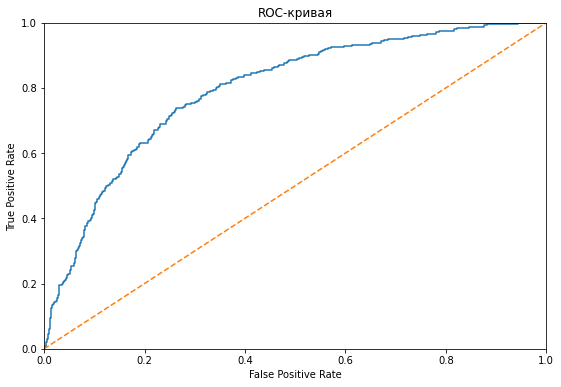

In [42]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid)
print('F1 модели логистической регрессии:', f1)
print('ROC_auc:', roc_auc)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_log, tpr_log, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_log, tpr_log)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

<Figure size 432x288 with 0 Axes>

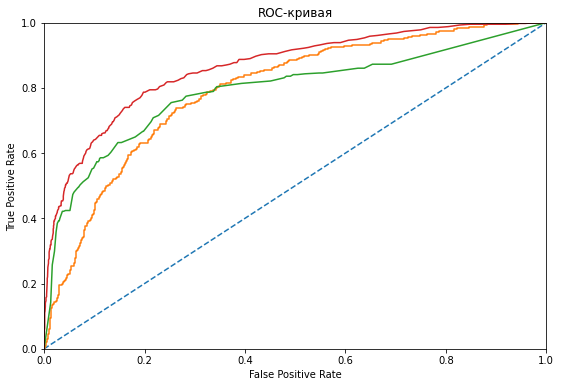

In [43]:
plt.figure()
plt.figure(figsize=(9,6));
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log, tpr_log, label = 'Логистическая регрессия')
plt.plot(fpr_tree, tpr_tree, label = 'Решающее дерево')
plt.plot(fpr_forest, tpr_forest, label = 'Случайный лес')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

При сравнении моделей после взвешивания классов и увеличения выборки лучшим значением F1-меры (0.65) обладает случайный лес, полученный методом взвешивания классов, с количеством деревьев 20 и глубиной деревьев 11. Теперь проведем уменьшение выборки и сравним результаты.

**Уменьшение выборки**

1    0.50569
0    0.49431
Name: exited, dtype: float64


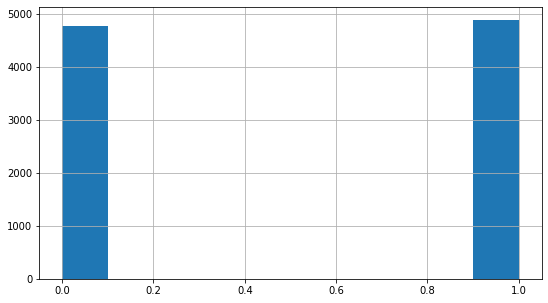

In [44]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_upsampled.value_counts(normalize = 1))
target_upsampled.hist(figsize=(9, 5));

1. Решающее дерево

2. Случайный лес

F1-мера лучшей модели:  0.6286799620132953
Количество деревьев лучшей модели:  110
Глубина деревьев лучшей модели:  8
AUC-ROC модели: 0.8608368127401714


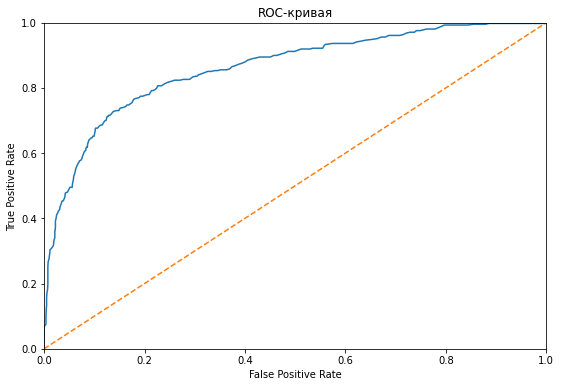

In [46]:
best_forest = None
best_f1 = 0
best_est = 0
best_depth = 0
for est in range(10, 250, 10):
    for depth in range(1, 50):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        if f1 > best_f1:
            best_forest = model
            best_f1 = f1
            best_est = est
            best_depth = depth
print('F1-мера лучшей модели: ', best_f1)
print('Количество деревьев лучшей модели: ', best_est)
print('Глубина деревьев лучшей модели: ', best_depth) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_forest, tpr_forest)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

3. Логистическая регрессия

F1 модели логистической регрессии: 0.6024321796071095
ROC_auc: 0.7881379938910237
AUC-ROC модели: 0.792608877721943


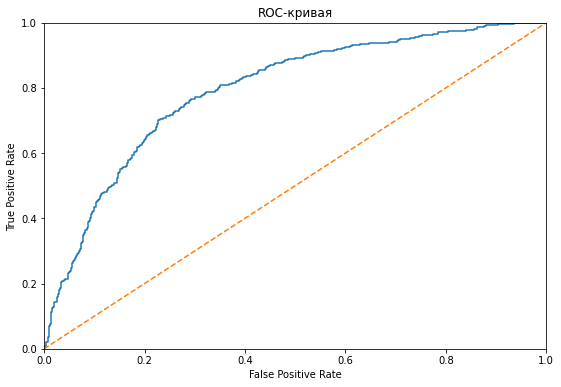

In [47]:
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
roc_auc = roc_auc_score(target_valid, predictions_valid)
print('F1 модели логистической регрессии:', f1)
print('ROC_auc:', roc_auc)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_log, tpr_log, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr_log, tpr_log)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

<Figure size 432x288 with 0 Axes>

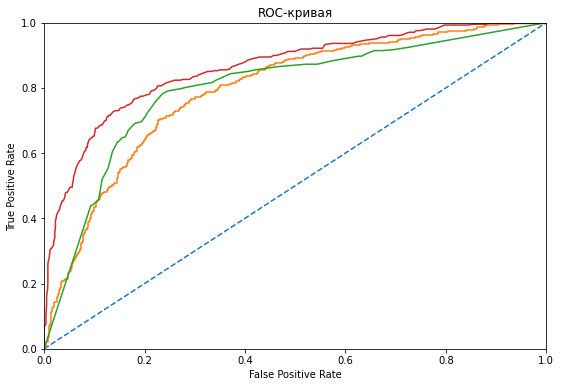

In [48]:
plt.figure()
plt.figure(figsize=(9,6));
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log, tpr_log, label = 'Логистическая регрессия')
plt.plot(fpr_tree, tpr_tree, label = 'Решающее дерево')
plt.plot(fpr_forest, tpr_forest, label = 'Случайный лес')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**Вывод**\
\
В данном разделе мы сбалансировали данные разными методами и после этого обучили модели. Метрика F1 моделей логистической регрессии существенно ниже, чем у моделей решающего дерева и случайного леса.
На валидационной выборке наилучшее качество (F1=0.65) продемонстрировала модель случайного леса при применении метода взвешивание классов с гиперпараметрами: количество деревьев  20, максимальная глубина деревьев: 11. Проверим лучшую модель на тестовой выборке.

## Тестирование модели

F1: 0.6025917926565875
Полнота: 0.6855036855036855
AUC-ROC модели: 0.8551556178674823


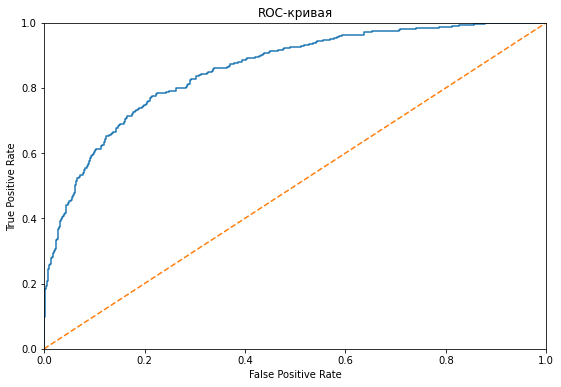

In [49]:
model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=9)
model.fit(features_upsampled, target_upsampled)
predictions_test = model.predict(features_test)

f1 = f1_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
print('F1:', f1)
print('Полнота:', recall)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC модели:', auc_roc)

plt.figure(figsize=(9,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Выбранная модель показывает хороший результат на тестовой выборке - значение F1 меры равно 0,60, что выше заданного порогового уровня 0,59. Значение AUC-ROC равно 0,85.

Так же была рассчитана метрика полнота, ее значение составило 0,67. Это говорит о том, что модель правильно определяет 67% тех клиентов, которые действительно уйдут/планируют уйти.

In [50]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
f1 = f1_score(predictions_dummy, target_test)
print('F1 константной модели:', f1)

F1 константной модели: 0.3381803074366431


Accuracy модели DummyClassifier значительно ниже, чем у модели Случайного леса. Из чего можно сделать вывод, что выбранная модель адекватна.

**Вывод**\
\
\
При первоначальной обработке данных пропуски в стотлбце tenure были заполненны медианой. Изменен формат данных в стобце tenure. Были удалены столбцы row_number, customer_id, surname, так как они не несли информации для обучения моделей. Категориальные признаки были преобразованны в численные при помощи OHE. Далее данные были разбиты на три выборки в соотношении 3:1:1.(60%:20%:20%). Численные признаки были стандартизированны.\
Был выявлен дисбаланс классов в соотношении 1:4. Для устранения дисбаланса были применены методы взвешивание классов, увеличение выборки, уменьшение выборки. На новых данных все модели показали результат выше, чем на несбалансированной выборке.\
Наибольшие показатели F1(0.62988) и AUC-ROC(0.84) полученны у модели Случайного леса при применении метода взвешивание классов с параметрами (Глубина дерева: 9, Количество деревьев: 90).\
Лучшая модель была проверена на тестовой выборке и показала значение F1-меры в размере 0,61, AUC-ROC в размере 0,85. Была рассчитана полнота, ее значение составило 0,63.\ 
Финальная модель прошла проверку на адекватность.